In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
import os
import dotenv
dotenv.load_dotenv()

import warnings; warnings.simplefilter('ignore')

In [30]:
TARGET_HEIGHT = int(os.environ['TARGET_HEIGHT'])
TARGET_WIDTH = int(os.environ['TARGET_WIDTH'])
N_CHANNELS = int(os.environ['N_CHANNELS'])
IMAGE_FORMAT = os.environ['IMAGE_FORMAT']
IMAGE_QUALITY = int(os.environ['IMAGE_QUALITY'])
RECORD_DIR = 'data/tfrecords'
N = 16

In [33]:
# Function to decode the TFRecords
def decode_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
        'patient_id': tf.io.FixedLenFeature([], tf.int64),
        'image_id': tf.io.FixedLenFeature([], tf.int64),
    })
    if IMAGE_FORMAT == 'PNG':
        image = tf.io.decode_png(features['image'], channels=N_CHANNELS)
    else:
        image = tf.io.decode_jpeg(features['image'], channels=N_CHANNELS)
        
    image = tf.reshape(image, [TARGET_HEIGHT, TARGET_WIDTH, N_CHANNELS])

    target = features['target']
    patient_id = features['patient_id']
    image_id = features['image_id']
    
    return image, target, patient_id, image_id

# Sample TFRecord Dataset
def get_train_dataset():
    # Read all TFRecord file paths
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob(f'{RECORD_DIR}/*.tfrecords')
    # initialize TFRecord dataset
    train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    # Decode samples by mapping with decode function
    train_dataset = train_dataset.map(decode_tfrecord)
    # Batch samples
    train_dataset = train_dataset.batch(N)
    
    return train_dataset

# Shows a batch of images
def show_batch(dataset, rows=N, cols=1):
    images, targets, patient_ids, image_ids = next(iter(dataset))
    images = np.moveaxis(images, 3, 1)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*10))
    for r in range(rows):
        for c in range(cols):
            img = images[r,c]
            axes[r].imshow(img)
            if c == 0:
                target = targets[r]
                patient_id = patient_ids[r]
                image_id = image_ids[r]
                axes[r].set_title(f'target: {target}, patient_id: {patient_id}, image_id: {image_id}', fontsize=12, pad=16)
        
    plt.show()

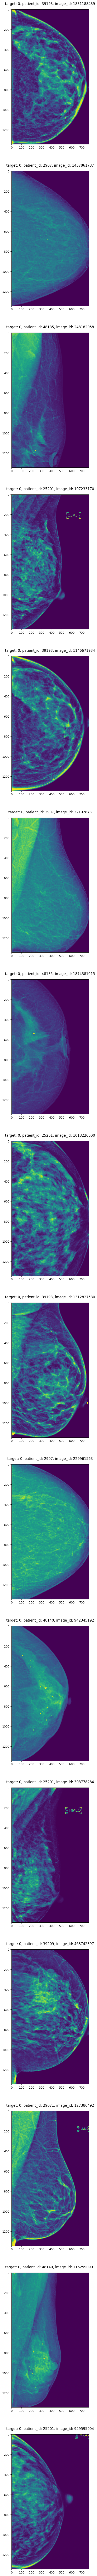

In [34]:
# Show Example Batch
train_dataset = get_train_dataset()
show_batch(train_dataset)